# Heartbeat Prediction


In [1]:
cuda_NO = 0
fix_rand_seed = 1 #TODO: change to 1
rand_seed = 37
batch_size = 16
model_save_path = "best_heartbeat_model.pth"

!nvidia-smi
import torch
print(torch.cuda.is_available())
device = f"{cuda_NO}" if torch.cuda.is_available() else "cpu"
print(device)

zsh:1: command not found: nvidia-smi
False
cpu


## Set random seed

In [2]:
import numpy as np
import random

def set_rand_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

if fix_rand_seed:
    set_rand_seed(rand_seed)

## Read data

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_data = pd.read_csv('train.csv', header=0)

## Check data

In [4]:
# check the data and labels
print(train_data.head())
print(f"labels contain: {train_data['label'].unique()}")

   id                                  heartbeat_signals  label
0   0  0.9912297987616655,0.9435330436439665,0.764677...    0.0
1   1  0.9714822034884503,0.9289687459588268,0.572932...    0.0
2   2  1.0,0.9591487564065292,0.7013782792997189,0.23...    2.0
3   3  0.9757952826275774,0.9340884687738161,0.659636...    0.0
4   4  0.0,0.055816398940721094,0.26129357194994196,0...    2.0
labels contain: [0. 2. 3. 1.]


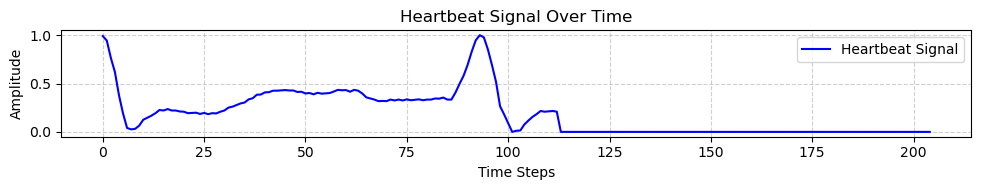

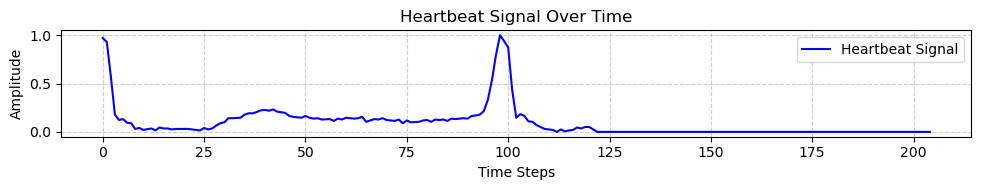

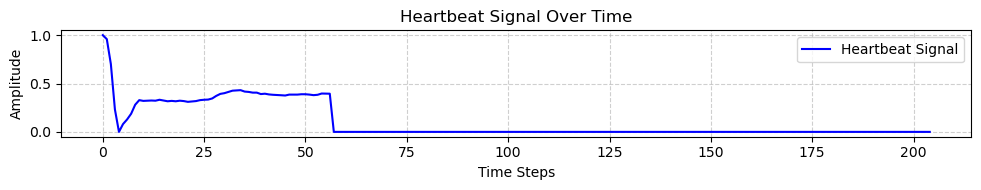

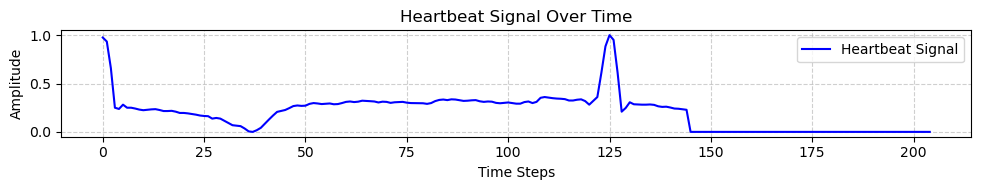

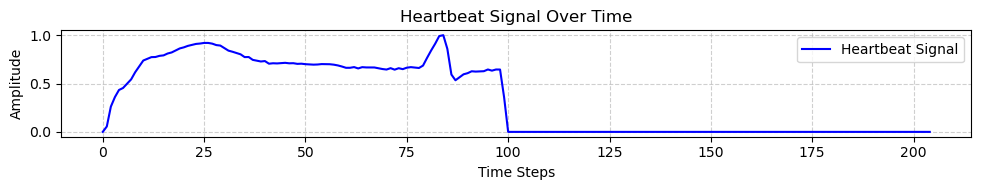

In [5]:
from matplotlib import pyplot as plt

def plot_signal(sample_index):
    heartbeat_signal = train_data['heartbeat_signals'].iloc[sample_index]
    vector = list(map(float, heartbeat_signal.split(',')))

    plt.figure(figsize=(10, 2))
    plt.plot(vector, label="Heartbeat Signal", color='blue')
    plt.title("Heartbeat Signal Over Time")
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude")
    plt.grid(linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

for i in range(5):
    plot_signal(i)

Category Distribution：
       Count  Percentage(%)
label                      
0.0    64327         64.327
3.0    17912         17.912
2.0    14199         14.199
1.0     3562          3.562


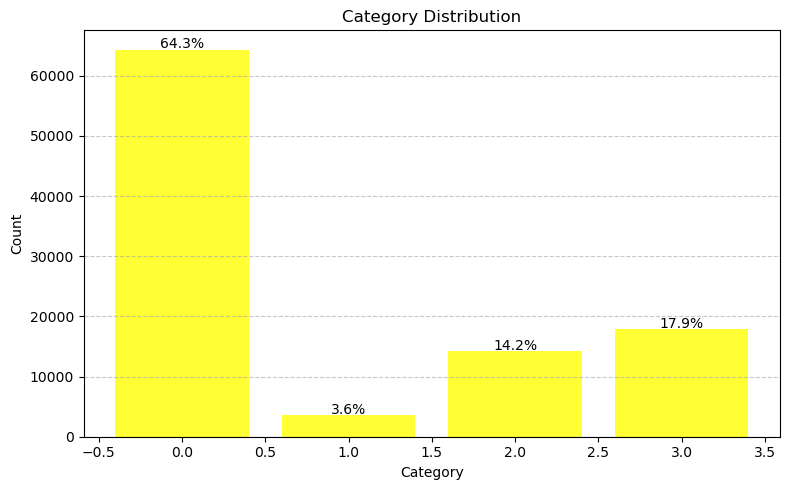

In [6]:
# data distribution
category_counts = train_data['label'].value_counts()
category_percentages = category_counts / len(train_data) * 100
category_distribution = pd.DataFrame({
    'Count': category_counts,
    'Percentage(%)': category_percentages
})
print("Category Distribution：")
print(category_distribution)
# visualization
plt.figure(figsize=(8, 5))
plt.bar(category_counts.index, category_counts.values, alpha=0.8, color='yellow')

for idx, val in category_counts.items():
    plt.text(idx, val+200, f"{category_percentages[idx]:.1f}%", ha='center')

plt.title('Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Preprocessing

In [7]:
# normalization
def normalize_signal(signal):
    return (signal - np.mean(signal)) / np.std(signal)

def to_array(signal):
    return np.array(list(map(float, signal.split(','))))

# preprocessing
def preprocess_signal(signal):
    signal = to_array(signal) # this comes first!
    # data is already normalized
    return signal

## Split

In [8]:
X = train_data['heartbeat_signals']
y = train_data['label']

X = X.apply(preprocess_signal)
y = y.apply(lambda x: int(x))

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=rand_seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=rand_seed)

In [9]:
# TODO: delete
print(max([len(signal) for signal in X]))
print(min([len(signal) for signal in X]))
print(X.shape)
print(X.head())
print(y.head())

205
205
(100000,)
0    [0.9912297987616655, 0.9435330436439665, 0.764...
1    [0.9714822034884503, 0.9289687459588268, 0.572...
2    [1.0, 0.9591487564065292, 0.7013782792997189, ...
3    [0.9757952826275774, 0.9340884687738161, 0.659...
4    [0.0, 0.055816398940721094, 0.2612935719499419...
Name: heartbeat_signals, dtype: object
0    0
1    0
2    2
3    0
4    2
Name: label, dtype: int64


## Dataset and dataloader

In [10]:
from torch.utils.data import DataLoader, Dataset

class HeartbeatDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        signal = self.data[index]
        label = self.labels[index]
        return signal, label

train_dataset = HeartbeatDataset(X_train, y_train)
val_dataset = HeartbeatDataset(X_val, y_val)
test_dataset = HeartbeatDataset(X_test, y_test)

#TODO: shuffle=True
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Model
We build the classification model based on several famous networks, and added our own adjustment to make use of the task's features.
- CNN: extract local feature.
- RNN(LSTM): make use of the feature in time dimension.
- Attention based networks: 捕捉长距离特征，自动关注对模型当前最重要的部分，同时使用multi-head attention。

In [11]:
import torch.nn as nn

class HeartbeatModel(nn.Module):
    def __init__(self, input_size, num_classes, num_layers, dropout):
        super(HeartbeatModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            #nn.Dropout(p=dropout)
        )
        self.rnn = nn.LSTM(input_size=32, hidden_size=64, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.attention = nn.MultiheadAttention(embed_dim=64*2, num_heads=4, batch_first=True)
        self.fc = nn.Linear(64*2, num_classes)
        #self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.cnn(x)
        x = x.permute(0, 2, 1)
        x, _ = self.rnn(x)
        x, _ = self.attention(x, x, x)
        # x = self.dropout(x)
        x = x.mean(dim=1)
        return self.fc(x)
#TODO: dropout!!!!!!!!!!!!!!!!!!

## Training

In [13]:
import torch, gc
from tqdm import tqdm
import torch.optim as optim

# clean gpu cache
gc.collect()
torch.cuda.empty_cache()

num_classes = 4

# hyper
input_dim = 205  # max length of the signal
hidden_dim = 128
output_dim = num_classes
num_layers = 2
dropout = 0.3
lr = 0.001
num_epochs = 20

criterion = nn.CrossEntropyLoss()

model = HeartbeatModel(input_size=input_dim, num_classes=output_dim, num_layers=num_layers, dropout=dropout)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
total_steps = len(train_loader) * num_epochs
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    model.to(device)
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        #TODO: delete

        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            signals, labels = batch
            signals, labels = signals.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(signals)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                signals, labels = batch
                signals, labels = signals.to(device), labels.to(device)

                outputs = model(signals)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, pred = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()

        val_accuracy = correct / total
        print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), model_save_path)
            print(f"Saved best model with accuracy: {best_accuracy:.4f}")

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Training Epoch 1/20:   0%|          | 0/5000 [00:00<?, ?it/s]


KeyError: 19430

## Prediction

In [ ]:
from sklearn.metrics import accuracy_score

model = HeartbeatModel(input_dim, num_classes, num_layers, dropout)
model.load_state_dict(torch.load("best_heartbeat_model.pth"), weights_only=True)

def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            signals, labels = batch
            signals, labels = signals.to(device), labels.to(device)

            outputs = model(signals)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Test Loss: {test_loss / len(test_loader):.4f}')
    print(f'Test Accuracy: {accuracy * 100:.2f}%')


test_model(model, test_loader, criterion)